In [105]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.optim as optim
from torchvision import transforms, models

In [106]:
vgg = models.vgg19(pretrained=True).features
for para in vgg.parameters():
    para.requires_grad_(False)

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [108]:
def loadImg(img_path, max_size = 500, shape=None):
    img = Image.open(img_path).convert('RGB')
    if max(img.size)>max_size:
        size = max_size
    else:
        size = max(img.size)
    if shape is not None:
        size = shape
    transform = transforms.Compose([transforms.Resize(size)
    ,transforms.RandomHorizontalFlip()
    ,transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)
    ,transforms.ToTensor()
    ,transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    img = transform(img)[:3,:,:].unsqueeze(0)
    
    return img           

Content Image and Style Image

In [109]:
content = loadImg('D:\\AI ML DL\\GANs\\content\\f79d9de05d.jpg').to(device)
style= loadImg('D:\\AI ML DL\\GANs\\style\\bc4b364a44.jpg' , shape =content.shape[-2:]).to(device)


In [110]:
def im_convert(tensor):
    img = tensor.to("cpu").clone().detach()
    img = img.numpy().squeeze()
    img = img.transpose(1,2,0)
    img = img * np.array((0.229,0.244,0.225))+np.array((0.485, 0.456, 0.406))
    img = img.clip(0,1)
    return img

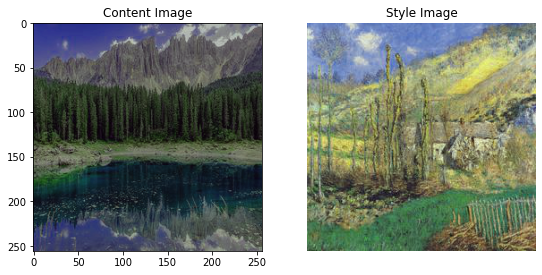

In [111]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(9,6))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image")
plt.axis('off')
ax2.imshow(im_convert(style))
ax2.set_title("Style Image")
plt.axis('off')
plt.show()

In [112]:
def getFeatures(img,model,layers=None):
    if layers is None:
        layers ={'0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  #content extractor and others for calucating gram matrix
        '28': 'conv5_1'}
    features ={}
    x=img
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] =x
    return features        

In [113]:
def gram_matrix(tensor):
    _, d,h,w = tensor.size()
    tensor = tensor.view(d,h*w)
    gram = torch.mm(tensor,tensor.t())
    return gram


In [114]:
print(type(content))

content_features = getFeatures(content,vgg)
style_features = getFeatures(style,vgg)

print(type(content_features))

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

<class 'torch.Tensor'>
<class 'dict'>


In [115]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.5,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

In [116]:
show_every = 400
optimizer = optim.Adam([target], lr=0.003)
steps = 300

for ii in range(1, steps+1):
    
    target_features = getFeatures(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
if  ii % show_every == 0:     
    print('Total loss: ', total_loss.item())
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()

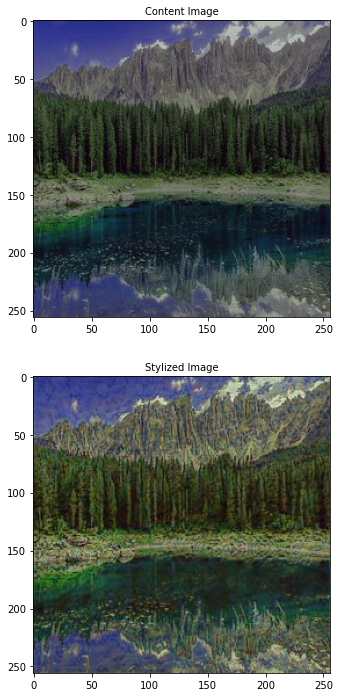

In [118]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,12))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize=10)
ax2.imshow(im_convert(target))
ax2.set_title("Stylized Image",fontsize=10)
ax1.grid(False)
ax2.grid(False)
plt.show()
